In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [ ]:
df = pd.read_csv('./dataset/TVNZ_movies_v3.csv')
df['mood'].fillna('', inplace = True)
df['texts'] = df['description'] + ', ' + df['genre'] + ', ' + df['mood']
df

,ID,title,description,tag,image,path,genre,mood,distributor,branded-vod,k_means,k_genre,GenreType,texts
0,0,Smoke & Mirrors,The true story of a man who fooled an entire c...,"genre:drama/crime-thriller,genre:drama,genre:d...",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,/Users/xutingxuan/Desktop/MSc ADS/B3_Personali...,"crime-thriller, drama, foreign-language-subtit...","thrilling, mysterious",rialto,filmstream,3,0,Thriller,The true story of a man who fooled an entire c...
1,1,Dede,A young woman living in a remote mountain vill...,"genre:drama,genre:drama/foreign-language-subti...",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,/Users/xutingxuan/Desktop/MSc ADS/B3_Personali...,"drama, foreign-language-subtitled, movie, real...","revealing, all-the-feels",rialto,filmstream,3,1,Drama,A young woman living in a remote mountain vill...
2,2,The Soul of Flies,A tale of two brothers who meet for the first ...,"genre:movie,genre:drama/foreign-language-subti...",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,/Users/xutingxuan/Desktop/MSc ADS/B3_Personali...,"movie, foreign-language-subtitled, comedy","quirky, irreverent, cheeky",rialto,filmstream,3,1,Drama,A tale of two brothers who meet for the first ...
3,3,The Unauthorised Melrose Place Story,Discover the drama that went on behind the cam...,"genre:movie,genre:closed-captions,genre:drama,...",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,/Users/xutingxuan/Desktop/MSc ADS/B3_Personali...,"movie, closed-captions, drama, real-life-stori...","nostalgic, all-the-feels",a-e,lifetime,5,2,Real Life Story,Discover the drama that went on behind the cam...
4,4,Stolen By My Mother: The Kamiyah Mobley Story,"Based on the true story, an 18-year-old girl f...","genre:movie,genre:drama,genre:drama/real-life-...",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,/Users/xutingxuan/Desktop/MSc ADS/B3_Personali...,"movie, drama, real-life-stories",,a-e,lifetime,2,2,Real Life Story,"Based on the true story, an 18-year-old girl f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,147,Gone Mom: The Disappearance of Jennifer Dulos,"Based on the true story of Jennifer Dulos, a w...","genre:movie,genre:drama/real-life-stories,genr...",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,/Users/xutingxuan/Desktop/MSc ADS/B3_Personali...,"movie, real-life-stories, drama, crime-thriller","mysterious, thrilling, all-the-feels",a-e,lifetime,2,0,Thriller,"Based on the true story of Jennifer Dulos, a w..."
148,148,Good Manners,"Clara, a lonely nurse from the outskirts of Sã...","genre:drama/crime-thriller,genre:drama,genre:d...",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,/Users/xutingxuan/Desktop/MSc ADS/B3_Personali...,"crime-thriller, drama, foreign-language-subtit...","mysterious, scary, all-the-feels",rialto,filmstream,3,1,Drama,"Clara, a lonely nurse from the outskirts of Sã..."
149,149,Beaches,"An update to a classic tear-jerker, we witness...","genre:movie,genre:drama,genre:closed-captions,...",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,/Users/xutingxuan/Desktop/MSc ADS/B3_Personali...,"movie, drama, closed-captions","all-the-feels, nostalgic, warm-and-fuzzy",a-e,lifetime,4,3,Romance,"An update to a classic tear-jerker, we witness..."
150,150,Resolve,"Based on the true story of Chris Crean, who to...","genre:movie,genre:drama,genre:drama/real-life-...",https://play-images-prod-ctf.tech.tvnz.co.nz/a...,/Users/xutingxuan/Desktop/MSc ADS/B3_Personali...,"movie, drama, real-life-stories, sunday-theatr...",,screentime,NaN,6,2,Real Life Story,"Based on the true story of Chris Crean, who to..."


In [ ]:
import spacy
alldesc = df.texts.values

nlp = spacy.load("en_core_web_sm")
processed_texts = [text for text in nlp.pipe(alldesc, 
                                              disable=["ner",
                                                       "parser"])]
df['ptexts'] = processed_texts #add processed_texts to a new column

# Tokenization, lemmatization, removing stop word, removing punctuations and filtering word type(nouns)
tokenized_texts_desc = [[word.lemma_.lower() for word in processed_text if word.pos_ == 'NOUN'or'VERD'or'ADJ' 
                                and not word.is_stop and not word.is_punct] for processed_text in processed_texts]

# Topic modeling

In [ ]:
import os   

!pip uninstall gensim
!pip install gensim==3.8.3

def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"    
  !java -version
install_java()


!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

!python -m spacy download nl_core_news_sm

In [ ]:
# Vectorization
from gensim.corpora import Dictionary

# Create a dictionary and filter out the words that occur less than two times, and all words that occur in over 70% of the documents.
MIN_DF = 2 # minium document frequency
MAX_DF = 0.7 # maximum document frequency

tokenized_texts = tokenized_texts_desc
dictionary = Dictionary(tokenized_texts) # get the vocabulary
dictionary.filter_extremes(no_below=MIN_DF, 
                           no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [ ]:
# Train the topic model
from gensim.models.wrappers import LdaMallet


PATH_TO_MALLET = 'mallet-2.0.8/bin/mallet'

N_TOPICS = 7 # k = 7: run a topic model with 8 topics
N_ITERATIONS = 1000

lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                optimize_interval=10, 
                iterations=N_ITERATIONS) 

In [ ]:
# Show the key words in each topic
for topic in range(N_TOPICS):
    words = lda.show_topic(topic, 20)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: life romantic romance star feel comedy turn world husband wife discover upside woman david good period cash kid spark psychological
Topic 1: closed caption zealand comedy 's star action starring family crack epic find pack ao te back maori good brother boy
Topic 2: series family feel casteel base dark mysterious v.c. ' andrews dollanganger heaven sibling life thriller crime 's past grandmother secret
Topic 3: story crime thriller thrilling true life mysterious real dark base 's suspenseful psychological star lead woman police sister inspire work
Topic 4: story life real make zealand feel caption nz true air reveal support sunday theatre closed star music epic lead base
Topic 5: family feel ( christmas love ) town small life romance romantic child find young relationship story girl fight comforting harry
Topic 6: subtitle english language foreign feel french spanish 's quirky thought family provoking woman comedy lavish village live irreverent back pack


In [ ]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

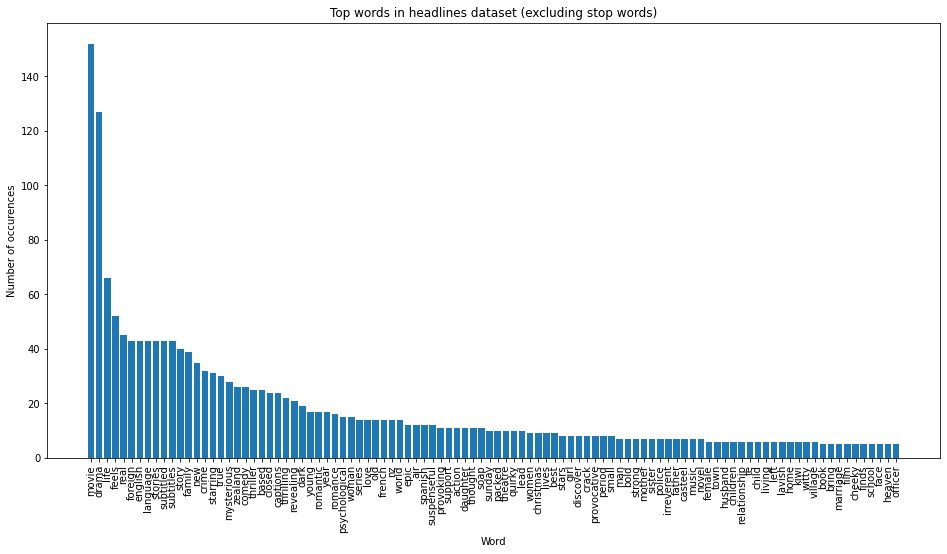

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=100,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['texts'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=4000)

small_document_term_matrix = small_count_vectorizer.fit_transform(df['texts'].values)

In [ ]:
n_topics = 7

In [ ]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [ ]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [ ]:
colormap = np.array([
    "#1f77b4", "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [ ]:
tsne_lda_model = TSNE(n_components=2, perplexity=40, learning_rate=200, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 152 samples in 0.000s...
[t-SNE] Computed neighbors for 152 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 152 / 152
[t-SNE] Mean sigma: 0.008439
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.417511
[t-SNE] KL divergence after 1550 iterations: 0.068262


In [ ]:
# get words
top_3_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

show(plot)
